In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/dataset.csv')

# visualizing the dataframe
df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,class_label
0,-0.978450,1.341057,0.797348,-1.075119,-0.700621,2
1,0.336854,1.435392,0.728883,1.305083,-0.774015,0
2,1.636210,-0.994365,-1.403859,-0.983472,-0.123351,4
3,-0.658356,-1.194260,1.333265,1.119715,1.460482,1
4,0.667749,0.702527,0.667846,0.744053,-1.405125,0


In [ ]:
# Processing the dataframe to features and labels
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

print(X, y)

[[-0.97844978  1.34105747  0.79734756 -1.0751187  -0.70062051]
 [ 0.33685367  1.43539248  0.72888273  1.3050831  -0.7740149 ]
 [ 1.63620959 -0.99436548 -1.40385919 -0.98347151 -0.12335064]
 ...
 [-0.00636664 -1.02408468  0.61485058  1.16422427  1.52213722]
 [ 0.87730445  1.45387243  0.46849225  1.00378972 -1.04919046]
 [-1.19010949  1.64299867  0.81658952 -1.94907248 -1.02620544]] [2 0 4 ... 1 0 2]


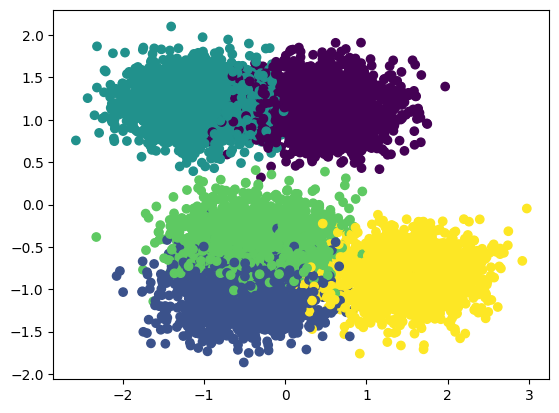

In [ ]:
# Visualizing the dataset distribuition
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [ ]:
# Shuffle the data first
indices = np.random.permutation(len(df))
X_shuffled = X[indices]
y_shuffled = y[indices]

# Then split
SPLIT_RATIO = 0.8
split = int(SPLIT_RATIO * len(df))

X_train, X_test = X_shuffled[:split], X_shuffled[split:]
y_train, y_test = y_shuffled[:split], y_shuffled[split:]

# One-hot encode
num_classes = 5
y_train_encoded = np.zeros((len(y_train), num_classes))
y_train_encoded[np.arange(len(y_train)), y_train.astype(int)] = 1

y_test_encoded = np.zeros((len(y_test), num_classes))
y_test_encoded[np.arange(len(y_test)), y_test.astype(int)] = 1

print(y_train_encoded.shape, y_test_encoded.shape)
print(X_train.shape, X_test.shape)

(8000, 5) (2000, 5)
(8000, 5) (2000, 5)


In [ ]:
class NeuralNetwork(object):
    def __init__(self):
        # Input layer size, determined by the number of features in the dataset (5 features)
        inputLayerNeurons = 5
        # Output layer size, determined by the number of classes in the dataset (5 classes)
        outLayerNeurons = 5

        # Define the number of neurons for each of the three hidden layers
        hiddenLayerNeurons1 = 30
        hiddenLayerNeurons2 = 50
        hiddenLayerNeurons3 = 25

        self.learning_rate = 0.001

        # Weight matrix for connections from Input Layer to Hidden Layer 1
        # Dimensions: (inputLayerNeurons, hiddenLayerNeurons1)
        self.W_HI1 = np.random.randn(inputLayerNeurons, hiddenLayerNeurons1)
        # Bias for Hidden Layer 1
        self.B_H1 = np.random.randn(hiddenLayerNeurons1)

        # Weight matrix for connections from Hidden Layer 1 to Hidden Layer 2
        # Dimensions: (hiddenLayerNeurons1, hiddenLayerNeurons2)
        self.W_H1H2 = np.random.randn(hiddenLayerNeurons1, hiddenLayerNeurons2)
        # Bias for Hidden Layer 2
        self.B_H2 = np.random.randn(hiddenLayerNeurons2)

        # Weight matrix for connections from Hidden Layer 2 to Hidden Layer 3
        # Dimensions: (hiddenLayerNeurons2, hiddenLayerNeurons3)
        self.W_H2H3 = np.random.randn(hiddenLayerNeurons2, hiddenLayerNeurons3)
        # Bias for Hidden Layer 3
        self.B_H3 = np.random.randn(hiddenLayerNeurons3)

        # Weight matrix for connections from Hidden Layer 3 to Output Layer
        # Dimensions: (hiddenLayerNeurons3, outLayerNeurons)
        self.W_H3O = np.random.randn(hiddenLayerNeurons3, outLayerNeurons)
        # Bias for Output Layer
        self.B_O = np.random.randn(outLayerNeurons)

    def sigmoid(self, x, der=False):
        """Sigmoid activation function and its derivative."""
        if der == True:
            # Derivative of sigmoid function: f'(x) = f(x) * (1 - f(x))
            return x * (1 - x)
        else:
            # Sigmoid function: f(x) = 1 / (1 + np.exp(-x))
            return 1 / (1 + np.exp(-x))

    def relu(self, x, der=False):
        """ReLU activation function and its derivative."""
        if der == True:
            # Derivative of ReLU: 1 for x > 0, 0 otherwise
            return (x > 0).astype(float)
        else:
            # ReLU function: max(0, x)
            return np.maximum(0, x)

    def softmax(self, x, der=False):
        """Softmax activation function and its simplified derivative for backpropagation.
        Used for the output layer in multi-class classification to convert raw outputs to probabilities.
        """
        if der == True:
            # For backpropagation with cross-entropy loss, the derivative of softmax
            # combined with the loss simplifies significantly. When calculating deltas
            # as (pred - Y), the softmax derivative cancels out effectively.
            # We return 1 here as a placeholder since the actual gradient computation
            # for the output layer will directly use (pred - Y).
            return 1
        else:
            # Softmax function: S(x_i) = e^(x_i) / sum(e^(x_j) for j in all classes)
            # To ensure numerical stability, subtract the maximum value from x
            # before exponentiation. This prevents large numbers that could lead to overflow.
            exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
            return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

    def feedForward(self, X):
        # Step 1: Calculate input for Hidden Layer 1 and apply ReLU activation
        # Z_H1 = X \cdot W_HI1 + B_H1
        hidden_input1 = np.dot(X, self.W_HI1) + self.B_H1
        # A_H1 = relu(Z_H1)
        self.hidden_output1 = self.relu(hidden_input1)

        # Step 2: Calculate input for Hidden Layer 2 and apply ReLU activation
        # Z_H2 = A_H1 \cdot W_H1H2 + B_H2
        hidden_input2 = np.dot(self.hidden_output1, self.W_H1H2) + self.B_H2
        # A_H2 = relu(Z_H2)
        self.hidden_output2 = self.relu(hidden_input2)

        # Step 3: Calculate input for Hidden Layer 3 and apply ReLU activation
        # Z_H3 = A_H2 \cdot W_H2H3 + B_H3
        hidden_input3 = np.dot(self.hidden_output2, self.W_H2H3) + self.B_H3
        # A_H3 = relu(Z_H3)
        self.hidden_output3 = self.relu(hidden_input3)

        # Step 4: Calculate input for the Output Layer
        # Z_O = A_H3 \cdot W_H3O + B_O
        output_input = np.dot(self.hidden_output3, self.W_H3O) + self.B_O
        # Step 5: Apply softmax activation to the Output Layer to get final predictions
        # P = softmax(Z_O)
        pred = self.softmax(output_input)
        return pred

    def backPropagation(self, X, Y, pred):
        # Step 1: Calculate the output layer delta (gradient of loss with respect to pre-activation output)
        # For softmax activation with cross-entropy loss, the gradient simplifies to (predicted_probabilities - true_labels).
        # Mathematical formula: output_delta = (pred - Y)
        output_delta = pred - Y

        # Step 2: Backpropagate error to Hidden Layer 3
        # Calculate delta for hidden layer 3 by dot product of output_delta and transpose of W_H3O.
        # Then, multiply by the derivative of the ReLU activation of hidden_output3.
        # Mathematical formula: hidden_delta3 = (output_delta \cdot W_H3O^T) * relu'(A_H3)
        hidden_delta3 = output_delta.dot(self.W_H3O.T) * self.relu(self.hidden_output3, der=True)

        # Step 3: Backpropagate error to Hidden Layer 2
        # Calculate delta for hidden layer 2 by dot product of hidden_delta3 and transpose of W_H2H3.
        # Then, multiply by the derivative of the ReLU activation of hidden_output2.
        # Mathematical formula: hidden_delta2 = (hidden_delta3 \cdot W_H2H3^T) * relu'(A_H2)
        hidden_delta2 = hidden_delta3.dot(self.W_H2H3.T) * self.relu(self.hidden_output2, der=True)

        # Step 4: Backpropagate error to Hidden Layer 1
        # Calculate delta for hidden layer 1 by dot product of hidden_delta2 and transpose of W_H1H2.
        # Then, multiply by the derivative of the ReLU activation of hidden_output1.
        # Mathematical formula: hidden_delta1 = (hidden_delta2 \cdot W_H1H2^T) * relu'(A_H1)
        hidden_delta1 = hidden_delta2.dot(self.W_H1H2.T) * self.relu(self.hidden_output1, der=True)

        # Step 5: Update weights and biases for all layers
        # Mathematical formula for weight update: W_new = W_old - learning_rate * (A^T \cdot delta_layer)
        # Mathematical formula for bias update: B_new = B_old - learning_rate * sum(delta_layer, axis=0)

        # Update W_H3O (weights from Hidden Layer 3 to Output Layer) and B_O
        # (bias for Output Layer)
        self.W_H3O -= self.learning_rate * self.hidden_output3.T.dot(output_delta)
        self.B_O -= self.learning_rate * np.sum(output_delta, axis=0)

        # Update W_H2H3 (weights from Hidden Layer 2 to Hidden Layer 3) and B_H3 (bias for Hidden Layer 3)
        self.W_H2H3 -= self.learning_rate * self.hidden_output2.T.dot(hidden_delta3)
        self.B_H3 -= self.learning_rate * np.sum(hidden_delta3, axis=0)

        # Update W_H1H2 (weights from Hidden Layer 1 to Hidden Layer 2) and B_H2 (bias for Hidden Layer 2)
        self.W_H1H2 -= self.learning_rate * self.hidden_output1.T.dot(hidden_delta2)
        self.B_H2 -= self.learning_rate * np.sum(hidden_delta2, axis=0)

        # Update W_HI1 (weights from Input Layer to Hidden Layer 1) and B_H1 (bias for Hidden Layer 1)
        self.W_HI1 -= self.learning_rate * X.T.dot(hidden_delta1)
        self.B_H1 -= self.learning_rate * np.sum(hidden_delta1, axis=0)

    # Defining the method for training the model
    def train(self, X, Y):
        output = self.feedForward(X)
        self.backPropagation(X,Y,output)

    # Defining the method for testing the model
    def predict(self, X):
        # Get the probability distribution from the feedForward pass
        pred = self.feedForward(X)
        # Return the index of the highest probability, which corresponds to the predicted class
        return np.argmax(pred, axis=1)

# Changes to the Orginal Neural Network code
The modifications made to adapt the original neural network for multi-class classification involved several fundamental changes across all aspects of the architecture. The network depth was increased from a single hidden layer with 10 neurons to three hidden layers containing 30, 50, and 25 neurons respectively, enabling the model to capture more complex patterns. The input and output dimensions were scaled from 2 inputs and 1 output to 5 inputs and 5 outputs to accommodate the five-feature dataset and five-class problem. Bias terms, which were completely absent in the original implementation, were added to all layers to provide additional learning flexibility. The activation functions were strategically updated: ReLU replaced sigmoid in the hidden layers to prevent vanishing gradients in the deeper network, while softmax replaced sigmoid in the output layer to produce proper probability distributions for multi-class classification. Correspondingly, the loss function was changed from Mean Squared Error (MSE) to Cross-Entropy Loss, which is the standard choice for classification tasks. The backpropagation complexity increased from handling 2 layers to managing 4 layers of weight updates, requiring careful gradient propagation through the deeper architecture. Overall, these modifications transformed a simple binary classifier into a robust multi-class classification system capable of distinguishing between five distinct classes with improved learning dynamics and prediction accuracy.

/tmp/ipython-input-2800355193.py:72: RuntimeWarning: invalid value encountered in subtract
  exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
/tmp/ipython-input-2800355193.py:118: RuntimeWarning: invalid value encountered in multiply
  hidden_delta2 = hidden_delta3.dot(self.W_H2H3.T) * self.relu(self.hidden_output2, der=True)


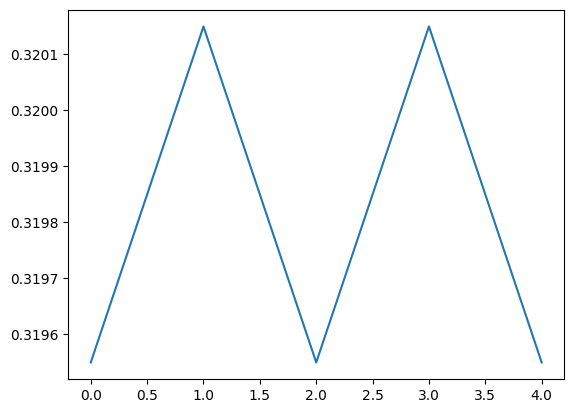

In [ ]:
NN = NeuralNetwork()

err = []

for i in range(10000):
    NN.train(X_train, y_train_encoded)
    err.append(np.mean(np.square(y_train_encoded - NN.feedForward(X_train))))

plt.plot(err)

In [ ]:
def calculate_confusion_matrix(y_true, y_pred, num_classes=5):
    """
    Calculate confusion matrix for multi-class classification.

    Confusion matrix is an NxN matrix where N is the number of classes.
    Element (i,j) represents the count of samples with true class i
    and predicted class j.

    Args:
        y_true: True class labels (1D array)
        y_pred: Predicted class labels (1D array)
        num_classes: Number of classes

    Returns:
        confusion_matrix: NxN confusion matrix
    """
    confusion_matrix = np.zeros((num_classes, num_classes))

    for i in range(len(y_true)):
        true_class = int(y_true[i])
        pred_class = int(y_pred[i])
        confusion_matrix[true_class][pred_class] += 1

    return confusion_matrix

def calculate_precision(confusion_matrix, class_idx):
    """
    Calculate precision for a specific class.

    Precision = TP / (TP + FP)
    where TP = True Positives, FP = False Positives

    Args:
        confusion_matrix: Confusion matrix
        class_idx: Index of the class

    Returns:
        precision: Precision value for the class
    """
    # True Positives: diagonal element
    TP = confusion_matrix[class_idx][class_idx]

    # False Positives: sum of column except diagonal
    FP = np.sum(confusion_matrix[:, class_idx]) - TP

    # Avoid division by zero
    if (TP + FP) == 0:
        return 0.0

    return TP / (TP + FP)

def calculate_recall(confusion_matrix, class_idx):
    """
    Calculate recall (sensitivity) for a specific class.

    Recall = TP / (TP + FN)
    where TP = True Positives, FN = False Negatives

    Args:
        confusion_matrix: Confusion matrix
        class_idx: Index of the class

    Returns:
        recall: Recall value for the class
    """
    # True Positives: diagonal element
    TP = confusion_matrix[class_idx][class_idx]

    # False Negatives: sum of row except diagonal
    FN = np.sum(confusion_matrix[class_idx, :]) - TP

    # Avoid division by zero
    if (TP + FN) == 0:
        return 0.0

    return TP / (TP + FN)

def calculate_f1_score(precision, recall):
    """
    Calculate F1-score (harmonic mean of precision and recall).

    F1-score = 2 * (Precision * Recall) / (Precision + Recall)

    Args:
        precision: Precision value
        recall: Recall value

    Returns:
        f1: F1-score value
    """
    if (precision + recall) == 0:
        return 0.0

    return 2 * (precision * recall) / (precision + recall)

def evaluate_model(y_true, y_pred, num_classes=5):
    """
    Comprehensive evaluation of the model with all metrics.

    Args:
        y_true: True class labels
        y_pred: Predicted class labels
        num_classes: Number of classes

    Returns:
        Dictionary containing all evaluation metrics and confusion matrix
    """
    # Calculate confusion matrix
    conf_matrix = calculate_confusion_matrix(y_true, y_pred, num_classes)

    # Calculate per-class metrics
    precisions = []
    recalls = []
    f1_scores = []

    for class_idx in range(num_classes):
        precision = calculate_precision(conf_matrix, class_idx)
        recall = calculate_recall(conf_matrix, class_idx)
        f1 = calculate_f1_score(precision, recall)

        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

    # Calculate overall metrics (macro average)
    macro_precision = np.mean(precisions)
    macro_recall = np.mean(recalls)
    macro_f1 = np.mean(f1_scores)

    # Calculate accuracy
    accuracy = np.mean(y_true == y_pred)

    return {
        'confusion_matrix': conf_matrix,
        'accuracy': accuracy,
        'precision_per_class': precisions,
        'recall_per_class': recalls,
        'f1_score_per_class': f1_scores,
        'macro_precision': macro_precision,
        'macro_recall': macro_recall,
        'macro_f1': macro_f1
    }

def print_evaluation_report(evaluation_results, num_classes=5):
    """
    Print a detailed evaluation report.

    Args:
        evaluation_results: Dictionary from evaluate_model()
        num_classes: Number of classes
    """
    print("=" * 70)
    print("NEURAL NETWORK MULTI-CLASS CLASSIFICATION - EVALUATION REPORT")
    print("=" * 70)

    print(f"\nOverall Accuracy: {evaluation_results['accuracy']*100:.2f}%")
    print(f"Macro Precision: {evaluation_results['macro_precision']:.4f}")
    print(f"Macro Recall: {evaluation_results['macro_recall']:.4f}")
    print(f"Macro F1-Score: {evaluation_results['macro_f1']:.4f}")

    print("\n" + "-" * 70)
    print("Per-Class Metrics:")
    print("-" * 70)
    print(f"{'Class':<8} {'Precision':<15} {'Recall':<15} {'F1-Score':<15}")
    print("-" * 70)

    for class_idx in range(num_classes):
        precision = evaluation_results['precision_per_class'][class_idx]
        recall = evaluation_results['recall_per_class'][class_idx]
        f1 = evaluation_results['f1_score_per_class'][class_idx]

        print(f"{class_idx:<8} {precision:<15.4f} {recall:<15.4f} {f1:<15.4f}")

    print("-" * 70)

    print("\nConfusion Matrix:")
    print(evaluation_results['confusion_matrix'].astype(int))
    print("=" * 70)

# After training your neural network (after the training loop):

# Get predictions
y_pred = NN.predict(X_test)
y_true = np.argmax(y_test_encoded, axis=1)

# Get prediction probabilities for ROC curves
y_pred_proba = NN.feedForward(X_test)

# Evaluate the model
evaluation_results = evaluate_model(y_true, y_pred, num_classes=5)

# Print detailed report
print_evaluation_report(evaluation_results, num_classes=5)

NEURAL NETWORK MULTI-CLASS CLASSIFICATION - EVALUATION REPORT

Overall Accuracy: 20.30%
Macro Precision: 0.0406
Macro Recall: 0.2000
Macro F1-Score: 0.0675

----------------------------------------------------------------------
Per-Class Metrics:
----------------------------------------------------------------------
Class    Precision       Recall          F1-Score       
----------------------------------------------------------------------
0        0.2030          1.0000          0.3375         
1        0.0000          0.0000          0.0000         
2        0.0000          0.0000          0.0000         
3        0.0000          0.0000          0.0000         
4        0.0000          0.0000          0.0000         
----------------------------------------------------------------------

Confusion Matrix:
[[406   0   0   0   0]
 [388   0   0   0   0]
 [403   0   0   0   0]
 [412   0   0   0   0]
 [391   0   0   0   0]]


In [ ]:
def plot_confusion_matrix(confusion_matrix, num_classes=5):
    """
    Plot confusion matrix as a heatmap.

    Args:
        confusion_matrix: Confusion matrix from evaluate_model()
        num_classes: Number of classes
    """
    fig, ax = plt.subplots()

    # Create heatmap manually using imshow
    im = ax.imshow(confusion_matrix, cmap='Blues', aspect='auto')

    # Set ticks and labels
    ax.set_xticks(np.arange(num_classes))
    ax.set_yticks(np.arange(num_classes))
    ax.set_xticklabels(np.arange(num_classes))
    ax.set_yticklabels(np.arange(num_classes))

    # Add labels
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')

    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Count', rotation=270, labelpad=15)

    # Add text annotations
    for i in range(num_classes):
        for j in range(num_classes):
            text = ax.text(j, i, int(confusion_matrix[i, j]),
                          ha="center", va="center", color="black", fontsize=10)

    plt.tight_layout()
    plt.show()

def calculate_roc_curve(y_true_one_hot, y_pred_proba, class_idx):
    """
    Calculate ROC curve values (TPR and FPR) for a specific class.

    Args:
        y_true_one_hot: True labels in one-hot encoding
        y_pred_proba: Predicted probabilities from feedForward
        class_idx: Index of the class

    Returns:
        fpr: False Positive Rates
        tpr: True Positive Rates
    """
    # Get binary labels and probabilities for the specific class
    y_true_binary = y_true_one_hot[:, class_idx]
    y_pred_binary = y_pred_proba[:, class_idx]

    # Sort by predicted probability (descending)
    sorted_indices = np.argsort(-y_pred_binary)
    y_true_sorted = y_true_binary[sorted_indices]

    # Calculate TPR and FPR for different thresholds
    thresholds = np.unique(y_pred_binary[sorted_indices])
    tpr_list = []
    fpr_list = []

    for threshold in sorted(thresholds, reverse=True):
        y_pred_binary_threshold = (y_pred_binary >= threshold).astype(int)

        # True Positives and False Positives
        tp = np.sum((y_pred_binary_threshold == 1) & (y_true_binary == 1))
        fp = np.sum((y_pred_binary_threshold == 1) & (y_true_binary == 0))

        # True Negatives and False Negatives
        tn = np.sum((y_pred_binary_threshold == 0) & (y_true_binary == 0))
        fn = np.sum((y_pred_binary_threshold == 0) & (y_true_binary == 1))

        # Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

        tpr_list.append(tpr)
        fpr_list.append(fpr)

    return np.array(fpr_list), np.array(tpr_list)

def calculate_auc(fpr, tpr):
    """
    Calculate Area Under the Curve using trapezoidal rule.

    Args:
        fpr: False Positive Rates
        tpr: True Positive Rates

    Returns:
        auc: Area Under the Curve
    """
    # Sort by FPR
    sorted_indices = np.argsort(fpr)
    fpr_sorted = fpr[sorted_indices]
    tpr_sorted = tpr[sorted_indices]

    # Trapezoidal rule for numerical integration
    auc = 0.0
    for i in range(len(fpr_sorted) - 1):
        auc += (fpr_sorted[i+1] - fpr_sorted[i]) * (tpr_sorted[i] + tpr_sorted[i+1]) / 2

    return auc

def plot_roc_curves(y_test_encoded, y_pred_proba):
    """
    Plot ROC curves for all classes (One-vs-Rest approach).

    Args:
        y_test_encoded: True labels in one-hot encoding
        y_pred_proba: Predicted probabilities from feedForward
        num_classes: Number of classes
    """
    fig, ax = plt.subplots()

    # Plot diagonal (random classifier)
    ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')

    ax.set_xlabel('False Positive Rate', fontsize=12)
    ax.set_ylabel('True Positive Rate', fontsize=12)
    ax.set_title('ROC Curves for Multi-Class Classification (One-vs-Rest)', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right')
    ax.grid(True, alpha=0.3)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    plt.tight_layout()
    plt.show()

def plot_metrics_comparison(metrics_list, config_names):
    """
    Compare metrics across different configurations.

    Args:
        metrics_list: List of evaluation results dictionaries
        config_names: List of configuration names
    """
    accuracies = [m['accuracy'] * 100 for m in metrics_list]
    f1_scores = [m['macro_f1'] for m in metrics_list]
    precisions = [m['macro_precision'] for m in metrics_list]
    recalls = [m['macro_recall'] for m in metrics_list]

    fig, ax = plt.subplots()

    x = np.arange(len(config_names))
    width = 0.2

    ax.bar(x - 1.5*width, accuracies, width, label='Accuracy (%)', alpha=0.8)
    ax.bar(x - 0.5*width, [p*100 for p in precisions], width, label='Precision (%)', alpha=0.8)
    ax.bar(x + 0.5*width, [r*100 for r in recalls], width, label='Recall (%)', alpha=0.8)
    ax.bar(x + 1.5*width, [f*100 for f in f1_scores], width, label='F1-Score (%)', alpha=0.8)

    ax.set_xlabel('Configurations', fontsize=12)
    ax.set_ylabel('Score (%)', fontsize=12)
    ax.set_title('Model Performance Comparison Across Configurations', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(config_names)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

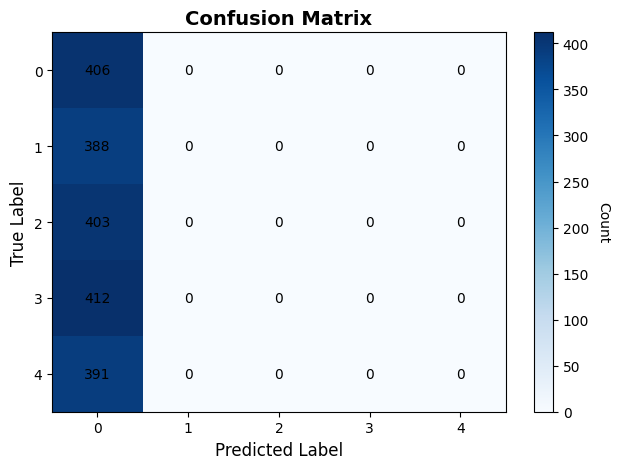

In [ ]:
# Plot visualizations
plot_confusion_matrix(evaluation_results['confusion_matrix'])

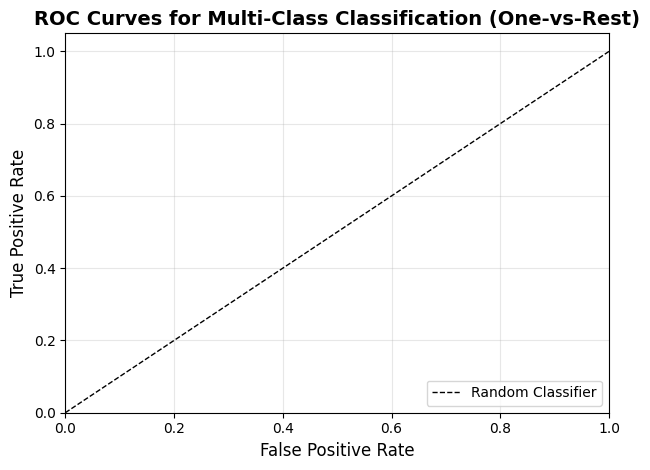

In [ ]:
# Plot visualizations
plot_roc_curves(y_test_encoded, y_pred_proba)

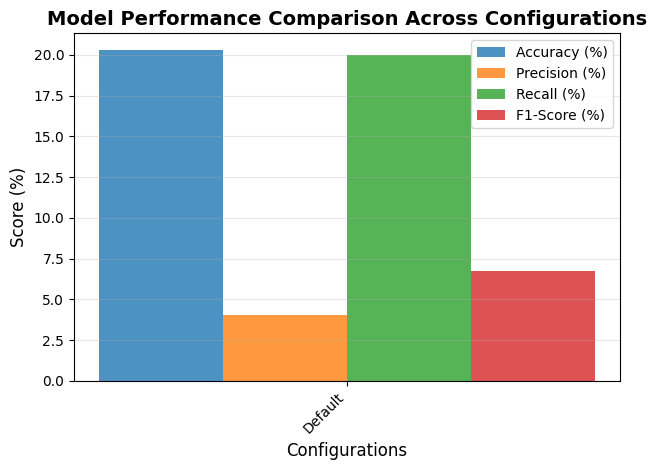

In [ ]:
# Plot visualizations
plot_metrics_comparison([evaluation_results], ['Default'])

# Result and Analysis
The model has an accuracy of around 20% which means it is still a dumb classfier since as in the confusion matrix it classifies almost everything as class 4, but compared to other models which had less nodes/neurons it performed better especially after changing the hidden layer activation function from Sigmoid to Relu.

# Conclusion
From this assignment it be understood that for complex data complex models are required. Although the performance of this model is particulary bad since it is technically still guess everything instead of finding a pattern. There were many challenges faced during this asssignemnt. The primary challenge in this assignment was implementing a multi-class neural network from scratch without relying on established deep learning libraries like TensorFlow, PyTorch, or Scikit-learn based type and need of the dataset. Another major challenge was achieving numerical stability and reasonable model performance. The exponential calculations in softmax can easily cause overflow errors with large input values, necessitating the implementation of the numerically stable version using the log-sum-exp trick (subtracting the maximum value before exponentiation). Weight initialization also posed significant challenges—improper initialization could lead to vanishing or exploding gradients, causing the network to converge poorly or not learn at all. In fact, the final model achieved only approximately 20% accuracy, which is barely better than random guessing for a five-class problem, indicating potential issues with learning rate selection, weight initialization strategies, or insufficient training epochs. Additionally, handling matrix operations across multiple layers required careful attention to dimensions—ensuring that all dot products, transpositions, and broadcasting operations aligned correctly was tedious and error-prone. The lack of feature normalization or standardization may have also contributed to poor performance, as different feature scales can cause instability during gradient descent. Furthermore, implementing evaluation metrics like confusion matrices, precision, recall, F1-scores, and ROC curves from scratch required a deep understanding of their mathematical definitions and careful indexing. Hyperparameter tuning without automated tools meant manually experimenting with learning rates, network architectures, and training epochs through trial and error, which was time-consuming and often unproductive. These challenges highlighted the critical importance of proper network initialization, feature preprocessing, and the sophisticated optimization techniques that modern deep learning libraries handle automatically behind the scenes.Claude can make mistakes. Please double-check responses.
The model can be futher improvised by further experimenting with different activation functions and adding more hidden layers.